--- FINAL PROJECT: Comprehensive Model Comparison ---
Comparing models on 48 future hours...

--- FINAL ERROR REPORT (RMSE) ---
Linear: 2.1730°C
Polynomial: 22.7441°C
Harmonic: 2.8967°C
Random Forest: 2.7704°C

 CONCLUSION: The BEST model for this dataset is LINEAR 
It had the lowest error deviation (2.17°C) from the actual forecast.


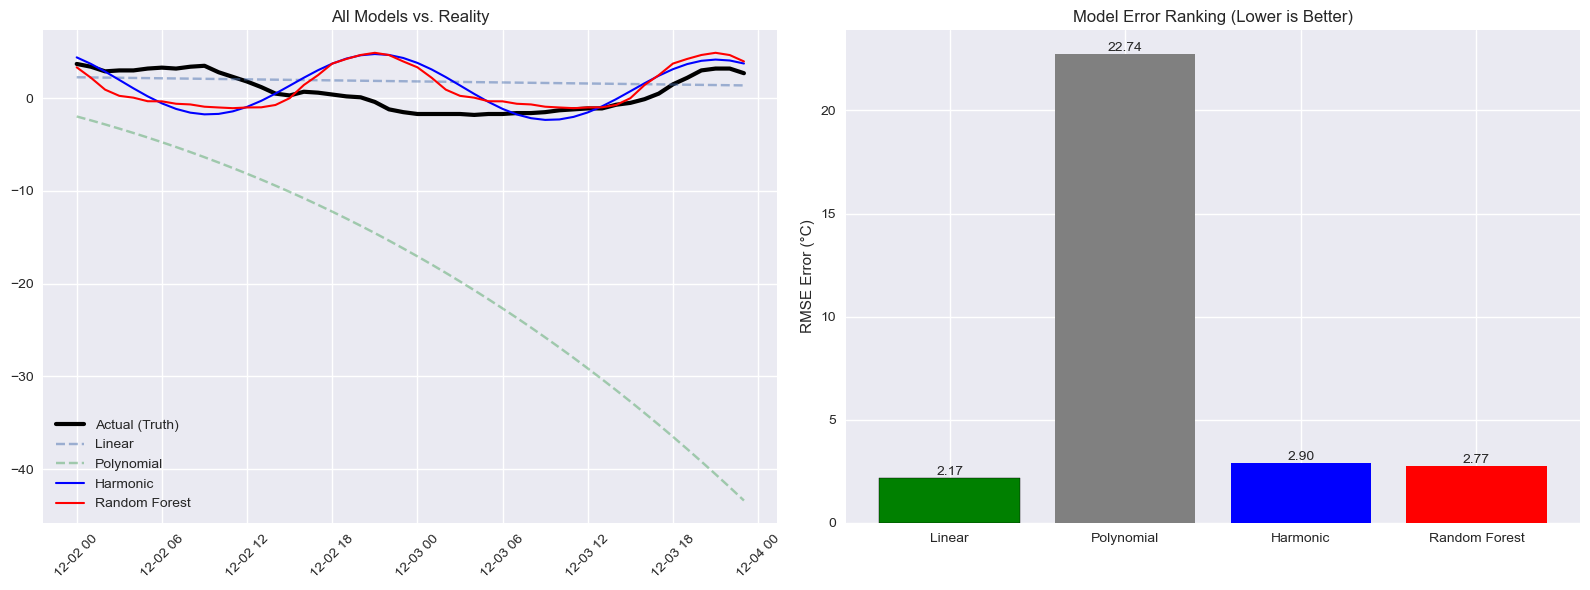

In [3]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.optimize import curve_fit
from datetime import datetime

LATITUDE = 36.17
LONGITUDE = -86.78
PAST_DAYS = 5
FORECAST_DAYS = 2

print("--- FINAL PROJECT: Comprehensive Model Comparison ---")

url = (
    f"https://api.open-meteo.com/v1/forecast?"
    f"latitude={LATITUDE}&longitude={LONGITUDE}"
    f"&hourly=temperature_2m"
    f"&past_days={PAST_DAYS}&forecast_days={FORECAST_DAYS}"
    f"&temperature_unit=celsius"
)
data = requests.get(url).json()['hourly']
df = pd.DataFrame({'time': pd.to_datetime(data['time']), 'temp': data['temperature_2m']})

df['timestamp'] = df['time'].apply(lambda x: x.timestamp())
df['hour_sin'] = np.sin(2 * np.pi * df['time'].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['time'].dt.hour / 24)

now = datetime.now()
train = df[df['time'] < now].copy()
test = df[df['time'] >= now].copy()

if test.empty:
    split = int(len(df) * 0.8)
    train, test = df.iloc[:split], df.iloc[split:]

print(f"Comparing models on {len(test)} future hours...")

lr = LinearRegression()
lr.fit(train[['timestamp']], train['temp'])
test['pred_linear'] = lr.predict(test[['timestamp']])

z = np.polyfit(train['timestamp'], train['temp'], 3)
p = np.poly1d(z)
test['pred_poly'] = p(test['timestamp'])

def harmonic(t, mean, amp, phase, trend):
    return mean + amp * np.sin(2 * np.pi * t / 86400 + phase) + trend * t

t0 = train['timestamp'].min()
popt, _ = curve_fit(harmonic, train['timestamp'] - t0, train['temp'],
                    p0=[15, 5, 0, 0])
test['pred_harmonic'] = harmonic(test['timestamp'] - t0, *popt)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(train[['timestamp', 'hour_sin', 'hour_cos']], train['temp'])
test['pred_rf'] = rf.predict(test[['timestamp', 'hour_sin', 'hour_cos']])

models = {
    "Linear": test['pred_linear'],
    "Polynomial": test['pred_poly'],
    "Harmonic": test['pred_harmonic'],
    "Random Forest": test['pred_rf']
}

results = {}
print("\n--- FINAL ERROR REPORT (RMSE) ---")
for name, preds in models.items():
    rmse = np.sqrt(mean_squared_error(test['temp'], preds))
    results[name] = rmse
    print(f"{name}: {rmse:.4f}°C")

best_model = min(results, key=results.get)
print(f"\n CONCLUSION: The BEST model for this dataset is {best_model.upper()} ")
print(f"It had the lowest error deviation ({results[best_model]:.2f}°C) from the actual forecast.")

plt.style.use('seaborn-v0_8')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(test['time'], test['temp'], 'k-', linewidth=3, label='Actual (Truth)')
ax1.plot(test['time'], test['pred_linear'], '--', alpha=0.5, label='Linear')
ax1.plot(test['time'], test['pred_poly'], '--', alpha=0.5, label='Polynomial')
ax1.plot(test['time'], test['pred_harmonic'], 'b-', linewidth=1.5, label='Harmonic')
ax1.plot(test['time'], test['pred_rf'], 'r-', linewidth=1.5, label='Random Forest')
ax1.set_title('All Models vs. Reality')
ax1.legend()
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

bars = ax2.bar(results.keys(), results.values(), color=['gray', 'gray', 'blue', 'red'])
ax2.set_title('Model Error Ranking (Lower is Better)')
ax2.set_ylabel('RMSE Error (°C)')
ax2.bar_label(bars, fmt='%.2f')

best_idx = list(results.keys()).index(best_model)
bars[best_idx].set_color('green')
bars[best_idx].set_edgecolor('black')

plt.tight_layout()
plt.savefig('model_performance_ranking.png')
plt.show()
